<a href="https://colab.research.google.com/github/peeyushsinghal/anomaly-detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection

## Multivariate Gaussian (Normal) Distribution

The basic approach of anomaly detection is defining a boundry around the normal data points that separates them from the outliers.
download the data from https://github.com/peeyushsinghal/anomaly-detection/tree/main/multivariate_gaussian_data to progress

In [7]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
	
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import csv
plt.style.use('ggplot')


In [8]:
#Let us explore our dataset. We first read them from our csv files
# Below files are list of lists, where inner list is [x1,x2] for train and cross validation
#  x1= throughput (mbps) and x2 = latency (ms)
tr = list(csv.reader(open("train_server_data.csv", "r"), delimiter=","))
cv = list(csv.reader(open("crossval_server_data.csv", "r"), delimiter=","))
ts = list(csv.reader(open("test_server_data.csv", "r"), delimiter=","))

In [13]:
# converting the above data into np array, to plot better
train_data = np.array(tr[: :]).astype("float")
crossval_data = np.array(cv[: :]).astype("float")
test_data = np.array(ts[: :]).astype("float")

In [14]:
print(train_data[1:5,:])

[[13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]


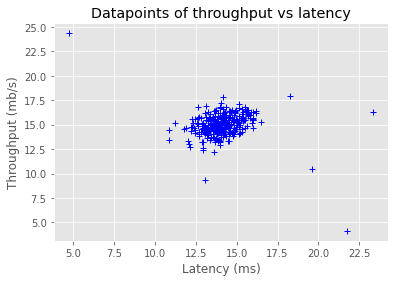

In [17]:
# Let us visualize our data
plt.figure(1)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Datapoints of throughput vs latency')
plt.plot(train_data[:,0], train_data[:,1],'b+')
plt.show()

In [21]:
#define the parameter and estimate the Gaussian distribution
def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

#define the multivariate Gaussian distribution
def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

Let's define a function ϵ that will help us get the optimal value for the threshold which will be use to separate the normal and the anomalous datapoints. We are going to make use of the cross validation dataset to learn the optimal values of ϵ. To achieve this, we are going to try different values in a range of learned probabilities. We will then calculate the f1-score for the predicted anomalies based on the ground truth available data. The ϵ with the highest value of f1-score will be our threshold. This means that the probability that lie below the selected threshold will be considered anomalous.

In [28]:
def select_threshold(probs, test_data):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    # print(max(probs), min(probs), stepsize)
    epsilons = np.arange(min(probs), max(probs), stepsize)
    # print(epsilons)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(test_data, predictions, average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon

    return best_f1, best_epsilon

In [29]:
mu, sigma = estimate_gaussian(train_data) #estimating the multivariate gaussian 
p = multivariate_gaussian(train_data,mu,sigma) # finding the probability density function for the dataset

#selecting optimal value of epsilon using cross validation
p_cv = multivariate_gaussian(crossval_data,mu,sigma) # using the same mu and sigma and finding pdf for cross val dataset
fscore, ep = select_threshold(p_cv,test_data)
print(fscore, ep)

#selecting outlier datapoints
outliers = np.asarray(np.where(p < ep))

0.8750000000000001 9.036201327981216e-05


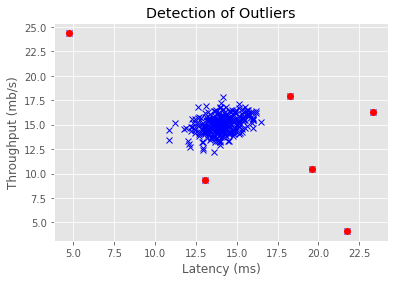

In [30]:
# plotting our outliers
plt.figure(2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Detection of Outliers')
plt.plot(train_data[:,0],train_data[:,1],'bx')
plt.plot(train_data[outliers,0],train_data[outliers,1],'ro')
plt.show()